In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#!pip install tensorflow==2.7.0

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')

In [ ]:
#path = '/content/drive/MyDrive/DL_Dataset/fake_or_real_news.csv'
data = pd.read_csv('./Dataset/fake_or_real_news.csv')
data

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [ ]:
data.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

Text(0, 0.5, '# of News Articles')

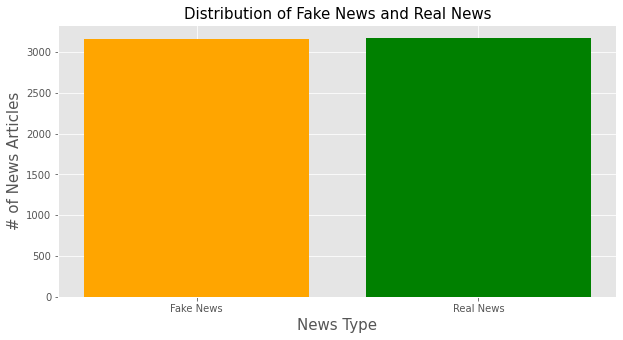

In [ ]:
data = data.replace({'REAL':1,'FAKE':0})


true = data[data.label==1]
fake = data[data.label==0]

plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake), color='orange')
plt.bar('Real News', len(true), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)

In [ ]:
print('Difference in news articles:',len(fake)-len(true))

Difference in news articles: -7


In [ ]:
data['text'] = data['title'] + data['text']
data.drop('title', axis=1, inplace=True)

In [ ]:
features = data['text']
targets = data['label']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [ ]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [ ]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [ ]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=35, shuffle=True, callbacks=[early_stop])

Epoch 1/10
131/131 [==============================] - 12s 48ms/step - loss: 0.6833 - accuracy: 0.5019 - val_loss: 0.6737 - val_accuracy: 0.5030
Epoch 2/10
131/131 [==============================] - 5s 36ms/step - loss: 0.5815 - accuracy: 0.6389 - val_loss: 0.5650 - val_accuracy: 0.7574
Epoch 3/10
131/131 [==============================] - 5s 36ms/step - loss: 0.3827 - accuracy: 0.8581 - val_loss: 0.4236 - val_accuracy: 0.8126
Epoch 4/10
131/131 [==============================] - 5s 37ms/step - loss: 0.2784 - accuracy: 0.8954 - val_loss: 0.3609 - val_accuracy: 0.8402
Epoch 5/10
131/131 [==============================] - 5s 36ms/step - loss: 0.2107 - accuracy: 0.9147 - val_loss: 0.3715 - val_accuracy: 0.8422
Epoch 6/10
131/131 [==============================] - 5s 36ms/step - loss: 0.1704 - accuracy: 0.9266 - val_loss: 0.4100 - val_accuracy: 0.8383


In [ ]:
from sklearn.metrics import f1_score

model.evaluate(X_test, y_test)
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 
      
print('Accuracy:', accuracy_score(binary_predictions, y_test))
print('Precision:', precision_score(binary_predictions, y_test))
print('Recall:', recall_score(binary_predictions, y_test))
print('F1 Score:', f1_score(binary_predictions, y_test))

40/40 [==============================] - 1s 20ms/step - loss: 0.3838 - accuracy: 0.8256
Accuracy: 0.8255722178374112
Precision: 0.723338485316847
Recall: 0.9176470588235294
F1 Score: 0.8089887640449437
